In [1]:
import time
import threading
import schedule

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import yfinance as yf
import yahoo_fin.stock_info as si

# yahoo_fin.stock_info module 
# 시장 상태 확인

In [4]:
dow_list = si.tickers_dow()
len(dow_list)

30

In [60]:
df = si.get_data(dow_list[0])
df.head()

,open,high,low,close,adjclose,volume,ticker
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100453,469033600,AAPL
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095213,175884800,AAPL
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088224,105728000,AAPL
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090408,86441600,AAPL
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093029,73449600,AAPL


In [82]:
price_df = df.loc[:, ['adjclose']].copy()

In [83]:
price_df['daily_rtn'] = price_df['adjclose'].pct_change()
price_df['st_rtn'] = (1 + price_df['daily_rtn']).cumprod()
price_df.head(10)

,adjclose,daily_rtn,st_rtn
1980-12-12,0.100453,NaN,NaN
1980-12-15,0.095213,-0.052171,0.947829
1980-12-16,0.088224,-0.073398,0.878261
1980-12-17,0.090408,0.024750,0.899998
1980-12-18,0.093029,0.028993,0.926091
1980-12-19,0.098707,0.061029,0.982610
1980-12-22,0.103511,0.048669,1.030433
1980-12-23,0.107879,0.042199,1.073916
1980-12-24,0.113556,0.052628,1.130434
1980-12-26,0.124038,0.092309,1.234783


In [84]:
# 1. 평균 회귀 전략
n = 20
sigma = 2
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = bb['adjclose'].rolling(n).mean()  # 중앙 이동 평균선
    bb['ub'] = bb['center'] + sigma * bb['adjclose'].rolling(n).std()  # 상단 밴드
    bb['lb'] = bb['center'] - sigma * bb['adjclose'].rolling(n).std()  # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)
bollinger

,adjclose,daily_rtn,st_rtn,center,ub,lb
1980-12-12,0.100453,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.095213,-0.052171,0.947829,NaN,NaN,NaN
1980-12-16,0.088224,-0.073398,0.878261,NaN,NaN,NaN
1980-12-17,0.090408,0.024750,0.899998,NaN,NaN,NaN
1980-12-18,0.093029,0.028993,0.926091,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-11-08,150.440002,-0.005553,1497.608653,148.110358,154.547918,141.672799
2021-11-09,150.809998,0.002459,1501.291901,148.585670,154.266484,142.904855
2021-11-10,147.919998,-0.019163,1472.522371,148.946437,153.275530,144.617345
2021-11-11,147.869995,-0.000338,1472.024598,149.162412,152.720340,145.604484


In [85]:
base_date = '2021-09-01'
sample = bollinger.loc[base_date:]
sample.head()

,adjclose,daily_rtn,st_rtn,center,ub,lb
2021-09-01,152.287735,0.004479,1516.002565,148.401913,152.973532,143.830295
2021-09-02,153.426071,0.007475,1527.334539,148.741917,153.748225,143.735609
2021-09-03,154.075134,0.004230,1533.795869,149.149323,154.505082,143.793563
2021-09-07,156.461655,0.015489,1557.553337,149.678551,155.720698,143.636404
2021-09-08,154.883957,-0.010084,1541.847582,150.153358,156.267842,144.038874


In [86]:
book = sample[['adjclose']].copy()
book['trade'] = ''
book.head()

,adjclose,trade
2021-09-01,152.287735,
2021-09-02,153.426071,
2021-09-03,154.075134,
2021-09-07,156.461655,
2021-09-08,154.883957,


In [87]:
def create_trade_book(sample):
    book = sample[['adjclose']].copy()
    book['trade'] = ''
    return book


In [88]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'adjclose'] > sample.loc[i, 'ub']:  # 상단 밴드 이탈 시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'adjclose']:  # 하방 밴드 이탈 시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':  # 이미 매수 상태라면
                book.loc[i, 'trade'] = 'buy'  # 매수 상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'
        elif sample.loc[i, 'ub'] >=  sample.loc[i, 'adjclose'] and sample.loc[i, 'adjclose'] >= sample.loc[i, 'lb']:  # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수 상태 유지
            else:
                book.loc[i, 'trade'] == ''  # 동작 안함
    return book


In [89]:
book = tradings(sample, book)
book.tail(10)

,adjclose,trade
2021-11-01,148.742920,
2021-11-02,149.801376,
2021-11-03,151.269241,
2021-11-04,150.740005,
2021-11-05,151.279999,
2021-11-08,150.440002,
2021-11-09,150.809998,
2021-11-10,147.919998,
2021-11-11,147.869995,
2021-11-12,149.990005,


In [90]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        # long 진입
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
            buy = book.loc[i, 'adjclose']
            print('진입일 : ', i, 'long 진입 가격 : ', buy)
        # long 청산
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell = book.loc[i, 'adjclose']
            rtn = (sell - buy) / buy + 1 #  손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ', i, 'long 진입 가격 : ', buy, 'long 청산 가격 : ', sell, '| return : ', round(rtn, 4))
        if book.loc[i, 'trade'] == '':  # 제로 포지션
            buy = 0.0
            sell = 0.0
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn =  acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc_return']  = acc_rtn
    print('Accumulated return : ', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [91]:
returns(book)

진입일 :  2021-09-20 00:00:00 long 진입 가격 :  142.731689453125
청산일 :  2021-10-19 00:00:00 long 진입 가격 :  142.731689453125 long 청산 가격 :  148.54319763183594 | return :  1.0407
Accumulated return :  1.0407


1.0407

In [95]:
temp_df = price_df.loc[base_date:, ['st_rtn']] / price_df.loc[base_date,['st_rtn']]
last_date = temp_df.index[-1]
temp_df.loc[last_date, 'st_rtn']

0.9849119202383005

In [106]:
last_date

Timestamp('2021-11-12 00:00:00')

In [107]:
base_date

'2021-09-01'

In [113]:
range = (last_date - datetime.strptime(base_date, '%Y-%m-%d')).days
CAGR = price_df.loc[base_date, 'st_rtn'] ** (range/len(price_df.loc[base_date:].index)) - 1
CAGR

25352.975446005676

In [96]:
print(base_date, last_date)

2021-09-01 2021-11-12 00:00:00


<AxesSubplot:>

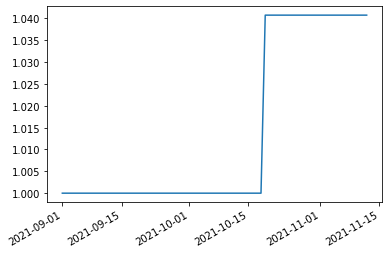

In [58]:
import matplotlib.pylab as plt
book['acc_return'].plot()

In [ ]:
# 2. 듀얼 모멘텀 전략
t_df = pd.DataFrame()

In [7]:
si.get_stats(dow_list[0])

,Attribute,Value
0,Beta (5Y Monthly),1.21
1,52-Week Change 3,24.68%
2,S&P500 52-Week Change 3,29.11%
3,52 Week High 3,157.26
4,52 Week Low 3,112.59
5,50-Day Moving Average 3,146.52
6,200-Day Moving Average 3,141.23
7,Avg Vol (3 month) 3,75.72M
8,Avg Vol (10 day) 3,58.21M
9,Shares Outstanding 5,16.41B


In [ ]:
t_dict = si.get_analysts_info('AMZN')
analysts_list = list(t_dict.keys())
analysts_list

In [ ]:
i = 2
print(analysts_list[i])
t_dict[analysts_list[i]]

In [ ]:
t_dict['Earnings Estimate']

In [ ]:
# slack message 보내기
import requests
from public_data_config import apisdata

def post_message(text):
    token=apisdata['slack']['token']
    channel = apisdata['slack']['channel']
    response = requests.post("https://slack.com/api/chat.postMessage",
        headers={"Authorization": "Bearer "+token},
        data={"channel": channel,"text": text}
    )
    print(response, datetime.now())

def get_ticker():
    ticker = 'MSFT'
    return ticker

def get_market_status(ticker):
    market_status = si.get_market_status()
    earnings_date = si.get_next_earnings_date(ticker)
    return market_status, earnings_date

In [ ]:
# 일정 시간마다 특정 함수 수행 스케줄링
schedule.every(1).minutes.do(get_ticker)
ticker = get_ticker()
schedule.every(1).minutes.do(get_market_status, ticker)
market_status, earnings_date = get_market_status(ticker)
text = 'make_time : %s, market_status : %s, ticker : %s, next_earning_date : %s'%(datetime.now(), market_status, ticker, earnings_date)
schedule.every(1).minutes.do(post_message,text)

# schedule.every().day.at("11:08").do(post_message,text)

while True:
    print('try : ', datetime.now())
    schedule.run_pending()
    time.sleep(10)
    

In [ ]:
dow_list = si.tickers_dow() ## 30개
nasdaq_list = si.tickers_nasdaq() ## 5066개
sp500_list = si.tickers_sp500()  ## 505개

"""
dow_list 와 nasdaq_list 의 중복 ticker는 APPL, AMGN, CSCO, HON, INTC, MSFT, WBA
dow_list 에 들어있는 모든 30개사는 sp500에 포함되어 있음


"""


dow_list

In [ ]:
ticker_list = dow_list + nasdaq_list + sp500_list
ticker_list - list(set(ticker_list))

# 분석 시작일

date_to = datetime.now().date() - timedelta(days=3)

# 과거 데이터 확인 기간
past_data_years = 1
delta = relativedelta(years=past_data_years)

# 데이터 시작일
date_from = date_to - delta
str_date_from = date_from.strftime('%Y-%m-%d')
str_date_to = date_to.strftime('%Y-%m-%d')
print('데이터 시작일 : ', str_date_from, str_date_to)

# 시장 종류
# 'S&P500', 'NASDAQ', 'NYSE', 'AMEX', 'SSE', 'SZSE', 'HKEX', 'TSE', 'HOSE', 'KRX'
market = 'NASDAQ'

In [ ]:
# 시장별 ticker 가져오기
market_list = ['S&P500', 'NASDAQ', 'NYSE', 'KRX']

ticker_dict = dict()
market_df = pd.DataFrame()

for i in range(len(market_list)):
    
    market = market_list[i]
    df = pd.DataFrame()
    if i == 0:
        df = fdr.StockListing(market)
        df['Symbol'] = df['Symbol'].str.replace('/.', '')
        df['Market'] = market
        market_df = df
        print(market_list[i])
    else:
        df = fdr.StockListing(market)
        df['Symbol'] = df['Symbol'].str.replace('/.', '')
        df['Market'] = market
        market_df = market_df.append(df)
        print(market_list[i])
market_df.to_pickle()

In [ ]:
market_df.groupby('Market')['Symbol'].nunique()

In [ ]:
def make_inverstment_performance_indicator(df, target_price, date):
    daily_rtn = 'daily_rnt' # 일별 수익률
    st_rtn = 'st_rtn'  # 전략 수익률 수익률 누적의 곱

    df[daily_rtn] = df[target_price].pct_change()  # 일별 수익률
    df[st_rtn] = (1 + df[daily_rtn]).cumprod()  # 전략 수익률 = 수익률의 누적 곱
    
    # CAGR = Compound Annual Growth Rate 연평균 복리 수익률, 수익률이 높을 수록 좋다.
    CAGR = df.loc[date, st_rtn] ** (252./len(df.index)) -1  # 특정 시점까지의  최종 누적 수익률의 누적 연도 제곱근, 금융공학에서 1년은 252 영업일

    # MDD = Maximum Draw Down 최대 낙폭, MDD 값이 크면 변동성이 심한 주식
    historical_max = df[target_price].cummax()
    daily_drawdown = df[target_price] / historical_max - 1.0
    historical_dd = daily_drawdown.cummin()
    MDD = historical_dd.min()

    # VOL = Volatility 휘발성, 변동성
    VOL = np.std(df[daily_rtn]) * np.sqrt(252.)

    # Sharp = ex-post Sharp ratio, 사후적 사프 비율
    # 샤프지수와 같은 공식을 사용하지만, 자산의 실현 수익률을 사용한다는 점에서 다르다.
    # 샤프지수는 위험 대비 수익성 지표를 의미함
    # 실현 수익률의 산술 평균 / 실현 수익률의 변동성으로 계산함
    # 보통 1 이상이면 좋다고 판단함

    Sharp = np.mean(df[daily_rtn]) / VOL

    return CAGR, Sharp, VOL, MDD
    


In [ ]:
data = yf.Ticker('MSFT')
df = data.history(period='1d', start=str_date_from, end=str_date_to)['Close'].reset_index().set_index('Date')
df.head()

In [ ]:
df.index[-1]

In [ ]:
select_stock_dict = dict()

CAGR_criteria = 0.05 # 연평균 복리 수익률(Compound Annual Growth Rate)
Sharp_criteria = 0.01  # 샤프 지수는 0.01 이상 되면 좋다고 판단한다. (VOL을 곱하기 100 해주면 Sharp는 1)
VOL_criteria = 0.60  # 변동성 지수는 60 이상 -> 하루하루 변동성이 크면서 성장해야 단타를 자주 하지 않을까?
MDD_criteria = -0.90  # 최대 낙폭은 1년 이내에 50%까지 하락한 경우가 있으면 허용한다.
target_price = 'Close'  # 일별 종가를 기준으로 계산한다.

for ticker in ticker_dict[market_list[0]]:
    df = yf.Ticker(ticker).history(period='1y')
    # df = fdr.DataReader(ticker, str_date_from, str_date_to)[target_price].reset_index().set_index('Date')
    
    if date_to in pd.to_datetime(df.index.tolist()):
        CAGR, Sharp, VOL, MDD = make_inverstment_performance_indicator(df, target_price, str_date_to)
        # print(ticker, CAGR, Sharp, VOL, MDD)
        if CAGR >= CAGR_criteria and Sharp >= Sharp_criteria and VOL >= VOL_criteria and MDD >= MDD_criteria:
            if ticker not in select_stock_dict:
                select_stock_dict[ticker] = dict(
                    CAGR = None,
                    Sharp = None,
                    VOL = None,
                    MDD = None
                )
            if ticker in select_stock_dict:
                select_stock_dict[ticker] = dict(
                    CAGR = CAGR,
                    Sharp = Sharp,
                    VOL = VOL,
                    MDD = -1*MDD*100
                )
select_stock_dict

In [ ]:
fdr.DataReader('AAPL', '2020-01-01', '2020-01-03')

In [ ]:
import pandas as pd

url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'

df_listing = pd.read_html(url, header=0)[0]

cols_ren = {'회사명':'Name', '종목코드':'Symbol', '업종':'Sector', '주요제품':'Industry', 

                    '상장일':'ListingDate', '결산월':'SettleMonth',  '대표자명':'Representative', 

                    '홈페이지':'HomePage', '지역':'Region', }

df_listing = df_listing.rename(columns = cols_ren)

df_listing['Symbol'] = df_listing['Symbol'].apply(lambda x: '{:06d}'.format(x))

df_listing['ListingDate'] = pd.to_datetime(df_listing['ListingDate'])

df_listing

In [ ]:
ms_df = fdr.DataReader(nasdaq_ticker_df.iloc[0]['Symbol'], str_start_date, str_today_date)
ms_df.head()

In [ ]:
price_df = ms_df['Close'].reset_index().set_index('Date')

In [ ]:
from_date = '2020-01-01'
to_date = '2021-01-01'
price_df.loc[from_date:to_date].plot(figsize=(16,9))

In [ ]:
# 일별 수익률
price_df['daily_rtn'] = price_df['Close'].pct_change()
price_df.head()

In [ ]:
# 바이앤 홀드 전략의 누적 곱 계산
price_df['st_rtn'] = (1 + price_df['daily_rtn']).cumprod()
price_df.head()

In [ ]:
price_df['st_rtn'].plot(figsize=(16,9))

In [ ]:
base_date = '2020-04-01'
tmp_df = price_df.loc[base_date:,['st_rtn']] / price_df.loc[base_date,['st_rtn']]
last_date = tmp_df.index[-1]
print('누적 수익 : ', tmp_df.loc[last_date, 'st_rtn'])
tmp_df.plot(figsize=(16,9))

In [ ]:
### 투자 성과 분석 지표
# 1. 연평균 복리 수익률
# 기하 평균 N 개의 변수를 모두 곱한 값의 제곱근
# 가장 최근일의 최종 누적 수익률의 누적 연도 제곱근을 구한다. 금융공학에서 1년은 252 영업일로 계산
# ** 제곱
CAGR = price_df.loc[str_today_date, 'st_rtn'] ** (252/len(price_df.index)) - 1
CAGR

In [ ]:
# 2. 최대 낙폭(MDD Maximum Daily Drawdown)
historical_max = price_df['Close'].cummax()
daily_drawdown = price_df['Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()


In [ ]:
historical_dd[-1]

In [ ]:
# 3. 변동성
# 변동성은 금융 자산의 방향성에 대한 불확실성과 가격 등락에 대한 위험 예상 지표로 해석
# 수익률의 표준편차를 변동성으로 계산함
VOL = np.std(price_df['daily_rtn']) * np.sqrt(252.)
VOL

In [ ]:
# 4. 샤프 지수
# 샤프 지수는 위험 대비 수익성 지표라고 볼 수 있다.
# Ra 는 자산 수익률 Rb 는 무위험 수익률
# 사후적 샤프 비율 ex-post Sharpe ratio
# 공식은 같지만 자산의 실현 수익률을 사용한다는 점에서 샤프 지수와 다름
# 실현 수익률의 산술 평균 / 실현 수익률의 변동성으로 계산함
Sharpe = np.mean(price_df['daily_rtn']) / np.std(price_df['daily_rtn']) * np.sqrt(252.)
Sharpe

In [ ]:
import threading, time, signal
from datetime import timedelta

wait_time_seconds = 1

class ProgramKilled(Exception):
    pass

def foo():
    print(time.ctime())

def signal_handler(signum, frame):
    raise ProgramKilled

class Job(threading.Thread):
    def __init__(self, interval, execute, *args, **kwargs):
        threading.Thread.__init__(self)
        self.daemon = False
        self.stopped = threading.Event()
        self.interval = interval
        self.execute = execute
        self.args = args
        self.kwargs = kwargs
    
    def stop(self):
        self.stopped.set()
        self.join()

    def run(self):
        while not self.stopeed.wait(self.interval.total_seconds()):
            self.execute(*self.args, **self.kwargs)


if __name__ == "__main__":
    signal.signal(signal.SIGTERM, signal_handler)
    signal.signal(signal.SIGINT, signal_handler)
    job = Job(interval=timedelta(seconds=wait_time_seconds), execute=foo)
    job.start()

    while True:
        try:
            time.sleep(1)
        except ProgramKilled:
            print("Program killed: running cleanup code")
            job.stop()
            break

In [ ]:
import requests
from public_data_config import apisdata

def post_message(token, channel, text):
    response = requests.post("https://slack.com/api/chat.postMessage",
        headers={"Authorization": "Bearer "+token},
        data={"channel": channel,"text": text}
    )
    print(response)
 
myToken = apisdata['slack']['token']
channel = apisdata['slack']['channel']
 
post_message(myToken,channel,"test_message")